I used machine learning below to predict the passengers that survived the Titanic crash. I submitted the results of my predictions on the Kaggle Titanic machine learning project. Let's see what's involved!

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

In [2]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')
holdout.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [3]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


Load functions.py to use the functions in this file.

In [4]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [5]:
def process_all(Df):
    Df = process_missing(Df)
    Df = process_age(Df)
    Df = process_fare(Df)
    Df = process_titles(Df)
    Df = process_cabin(Df)
    
    columns = ['Age_categories', 'Fare_categories', 'Title', 'Cabin_type', 'Sex']
    for col in columns:
        Df = create_dummies(Df, col)
        
    return Df

train = process_all(train)
holdout = process_all(holdout) 

In [6]:
print(type(train['SibSp']))
print(type(train['Parch']))          

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


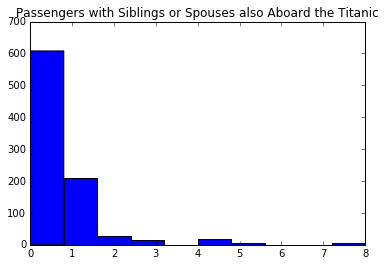

In [7]:
%matplotlib inline

plt.hist(train['SibSp'])
plt.title('Passengers with Siblings or Spouses also Aboard the Titanic')
plt.show()

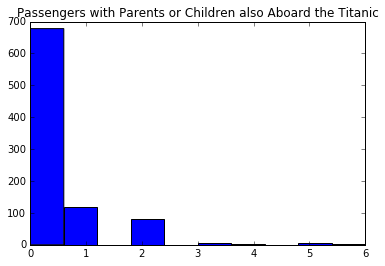

In [8]:
plt.hist(train['Parch'])
plt.title('Passengers with Parents or Children also Aboard the Titanic')

From the above histograms, we see that the majority of passengers were not traveling with family.

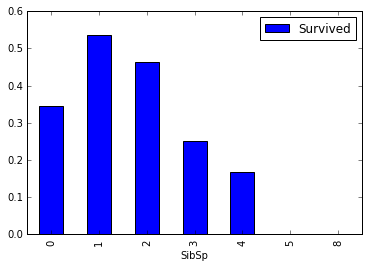

In [9]:
sibsp_pivot = train.pivot_table(index='SibSp', values='Survived')
sibsp_pivot.plot.bar()
plt.show()

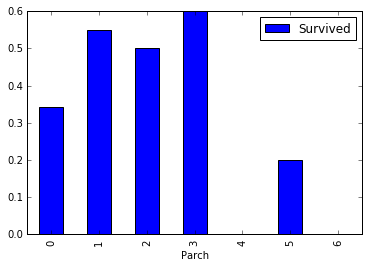

In [10]:
parch_pivot = train.pivot_table(index='Parch', values='Survived')
parch_pivot.plot.bar()
plt.show()

Someone traveling with one sibling or spouse had the highest survival rate. With more, their survival rate decreased steadily.

Among passengers traveling with a parent or child, there's no clear pattern although those passengers who were traveling with their parents or children had the highest survival rate. Interestingly, no one with four parents and children survived.

In [11]:
cols = ['SibSp', 'Parch', 'Survived']
cols = train[cols].copy()
print(cols.describe())
print(cols.info())

            SibSp       Parch    Survived
count  891.000000  891.000000  891.000000
mean     0.523008    0.381594    0.383838
std      1.102743    0.806057    0.486592
min      0.000000    0.000000    0.000000
25%      0.000000    0.000000    0.000000
50%      0.000000    0.000000    0.000000
75%      1.000000    0.000000    1.000000
max      8.000000    6.000000    1.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
SibSp       891 non-null int64
Parch       891 non-null int64
Survived    891 non-null int64
dtypes: int64(3)
memory usage: 21.0 KB
None


Below is Sibsp and Parch plotted together on a histogram.

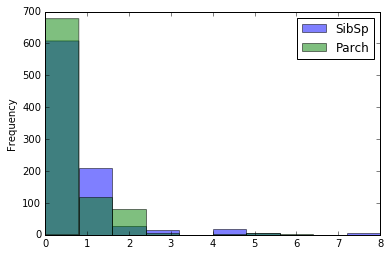

In [12]:
cols.drop('Survived', axis=1).plot.hist(alpha=0.5)
plt.show()

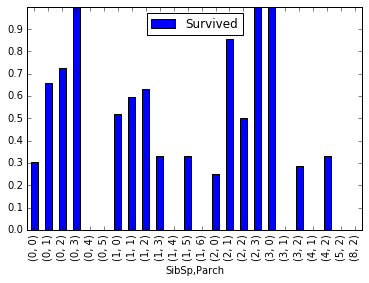

In [13]:
explore_cols = ['SibSp', 'Parch', 'Survived']
explore = train[explore_cols].copy()

explore['familysize'] = explore[['SibSp', 'Parch']].sum(axis=1)
pivot = explore.pivot_table(index=['SibSp', 'Parch'], values='Survived')
pivot.plot.bar(ylim=(0,1), yticks=np.arange(0,1,0.1))
plt.show()

In [14]:
def ask_alone(df):
    df['isalone'] = (~((df['SibSp'] >= 1) | (df['Parch'] >= 1))).astype(int)
#when function returns nothing,it returns None
ask_alone(train)#not assigned to train bc would make train None
ask_alone(holdout)#not assigned to holdout bc would make holdout None

Random Forest generates better algorithms than logistic regression. So we'll define a function that uses random forest to determine the best features for our model.

In [15]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(Df):
    Df = Df.dropna(axis=1)#drops columns with null values
    Df = Df.select_dtypes(include='number')
    drop_cols = ['PassengerId', 'Survived']
    all_X = Df.drop(labels=drop_cols, axis=1)
    all_y = Df['Survived']
    rf = RandomForestClassifier(random_state=1)
    rfv = RFECV(rf, cv=10)
    rfv.fit(all_X, all_y)
    best_params = rfv.get_support(list(all_X.columns))#gives index of selected columns
    best_columns = [list(all_X.columns)[i] for i in best_params]
    print(best_columns)
    return best_columns
    

In [16]:
rfecv_train = select_features(train)

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Young Adult', 'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [29]:
def select_model(Df, X):
    all_X = Df[X]
    all_y = Df['Survived']
    dictionary = [
    {
    "name": "LogisticRegression",
    "estimator": LogisticRegression(),
    "hyperparameters":
        {
            "solver": ["newton-cg", "lbfgs", "liblinear"]
        }
}, 
    {
    "name": "KNeighborsClassifier",
    "estimator": KNeighborsClassifier(),
    "hyperparameters":
        {
            "n_neighbors": range(1,20,2),
            "weights": ["distance", "uniform"],
            "algorithm": ["ball_tree", "kd_tree", "brute"],
            "p": [1,2]
        }
},
    {
    "name": "RandomForestClassifier",
    "estimator": RandomForestClassifier(),
    "hyperparameters":
        {
            "n_estimators": [4, 6, 9],
            "criterion": ["entropy", "gini"],
            "max_depth": [2, 5, 10],
            "max_features": ["log2", "sqrt"],
            "min_samples_leaf": [1, 5, 8],
            "min_samples_split": [2, 3, 5]
        }
}
    ]
    
    for d in dictionary:
        print(d["name"])
        gr = GridSearchCV(d["estimator"], d["hyperparameters"], cv=10)
        grfit = gr.fit(all_X, all_y)
        d['best_param'] = grfit.best_params_
        d['best_score'] = grfit.best_score_
        d['best_estimator'] = grfit.best_estimator_
        print("Best model parameters: ", d['best_param'], " and score: ", d['best_score'])
    return dictionary    

In [30]:
dscvr_best_model = select_model(train, rfecv_train)#best combination of hyperparameters and the score for that combination of hyperparameters

LogisticRegression
Best model parameters:  {'solver': 'liblinear'}  and score:  0.8204264870931538
KNeighborsClassifier
Best model parameters:  {'weights': 'uniform', 'p': 1, 'n_neighbors': 5, 'algorithm': 'brute'}  and score:  0.7755331088664422
RandomForestClassifier
Best model parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'max_features': 'sqrt', 'n_estimators': 9, 'criterion': 'entropy'}  and score:  0.8439955106621774


In [32]:
best_model_dict = max(dscvr_best_model, key=lambda d: d['best_score'])
best_model_dict

{'best_estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
             max_depth=10, max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=5, min_weight_fraction_leaf=0.0,
             n_estimators=9, n_jobs=1, oob_score=False, random_state=None,
             verbose=0, warm_start=False),
 'best_param': {'criterion': 'entropy',
  'max_depth': 10,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 9},
 'best_score': 0.8439955106621774,
 'estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
             verbose=0, warm_start=Fals

The best score was with the random forest model.

In [38]:
def save_submission_file(model, columns_list, filename='submission.csv'):
    holdout_submit = holdout[columns_list]
    holdout_predictions = model.predict(holdout_submit)
    submission = pd.DataFrame()
    submission['PassengerId'] = holdout['PassengerId']
    submission['Survived'] = holdout_predictions
    submission.to_csv(filename, index=False)

In [40]:
best_model = best_model_dict['best_estimator']
save_submission_file(best_model, rfecv_train)